In [6]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.special import i0, i1
from scipy.optimize import fsolve, root, minimize, LinearConstraint
import numdifftools as nd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from toy_models import *
import warnings
warnings.filterwarnings('ignore')

%matplotlib widget

In [7]:
def dot(a, b):
    '''Calculate dot product of two 2D vectors'''
    return np.dot(a, b)

def norm(v):
    '''Calculate norm of a 2D vector'''
    return np.sqrt(v[0]**2 + v[1]**2)

def constraint_phi1(x):
    '''Constraint that phi1 is a unit vector'''
    return x[0]**2 + x[1]**2 - 1

def constraint_phi2(x):
    '''Constraint that phi2 is a unit vector'''
    return x[2]**2 + x[3]**2 - 1

def free_energy(x, T, J12, J1, J2, omega1, omega2):
    '''phi1, phi2, omega1, omega2 are components of 2D vectors.
       x is a 1D array with the components of phi1 and phi2: [phi1_x, phi1_y, phi2_x, phi2_y]'''
    phi1 = x[:2]
    phi2 = x[2:4]
    return T/J12 * dot(phi1, phi2) + J1*J2/(J12*T) * dot(omega1, omega2) - 1/J12 * (J2*dot(phi1, omega2) + J1*dot(phi2, omega1)) - np.log(i0(norm(phi1))) - np.log(i0(norm(phi2)))

def free_energy_polar(phi, T, J12, J1, J2, omega1, omega2):
    '''phi = [phi1, phi2] are angles'''
    # Convert angles to Cartesian coordinates
    phi1 = [np.cos(phi[0]), np.sin(phi[0])]
    phi2 = [np.cos(phi[1]), np.sin(phi[1])]
    return T/J12 * dot(phi1, phi2) + J1*J2/T * dot(omega1, omega2) - 1/J12 * (J2*dot(phi1, omega2) + J1*dot(phi2, omega1)) - np.log(i0(norm(phi1))) - np.log(i0(norm(phi2)))



In [58]:
def find_minima(T, J12, J1, J2, omega1, omega2):
    # initial guess
    x0 = [1.0, 0.0, 1.0, 0.0]  # phi1 and phi2 start as unit vectors

    # define constraints
    cons = [{'type':'eq', 'fun':constraint_phi1}, {'type':'eq', 'fun':constraint_phi2}]

    # find minimum
    result = minimize(free_energy, x0, args=(T, J12, J1, J2, omega1, omega2), constraints=cons)
    
    phi1_sol = np.arctan2(result.x[1], result.x[0])
    phi2_sol = np.arctan2(result.x[3], result.x[2])

    hes = nd.Hessian(lambda phi: free_energy_polar(phi, T=100, J12=100, J1=100, J2=100, omega1=[np.cos(20), np.sin(20)], omega2=[np.cos(-20), np.sin(-20)]))([phi1_sol, phi2_sol])
    eigenvalues = np.linalg.eigvals(hes)

    # Check if it's a minimum
    # eigenvalues = np.linalg.eigvals(hes)
    if np.all(eigenvalues > 0):
        print('The solution is a minimum.')
    elif np.all(eigenvalues < 0):
        print('The solution is a maximum.')
    else:
        print('The solution is a saddle point.')
    
    return result.x, hes, eigenvalues

In [59]:
sol = find_minima(T=100, J12=100, J1=100, J2=100, omega1=[np.cos(20), np.sin(20)], omega2=[np.cos(-20), np.sin(-20)])

The solution is a minimum.


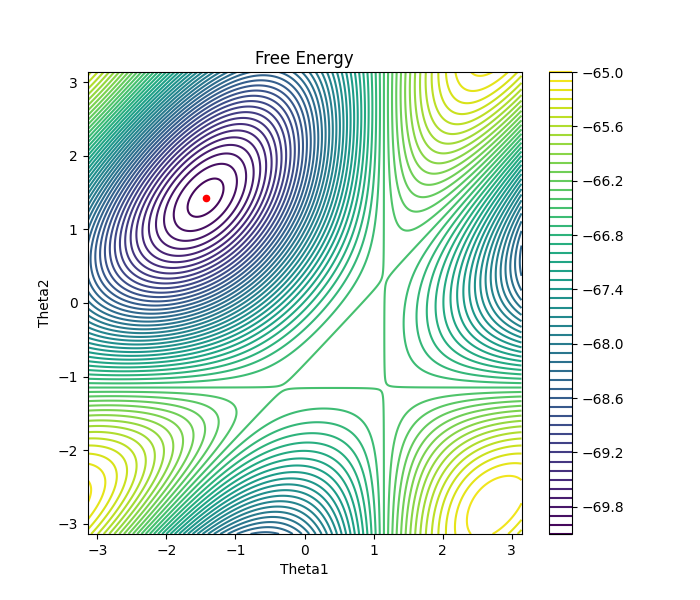

In [61]:
#PARAMETERS
omega1=[np.cos(20), np.sin(20)]
omega2=[np.cos(-20), np.sin(-20)]
T = 100
J12 = 100
J1 = 100
J2 = 100

theta1_values = np.linspace(-np.pi, np.pi, 500)
theta2_values = np.linspace(-np.pi, np.pi, 500)
theta1_grid, theta2_grid = np.meshgrid(theta1_values, theta2_values)

E_values = np.empty_like(theta1_grid)

for i in range(theta1_grid.shape[0]):
    for j in range(theta1_grid.shape[1]):
        theta = [theta1_grid[i, j], theta2_grid[i, j]]
        E_values[i, j] = free_energy_polar(theta, T, J12, J1, J2, omega1, omega2)

# Supposing `sol` is your solution
theta1_sol = np.arctan2(sol[0][1], sol[0][0])
theta2_sol = np.arctan2(sol[0][3], sol[0][2])


# Contour plot
plt.figure(figsize=(7,6))
contour = plt.contour(theta1_grid, theta2_grid, E_values, levels=50, cmap='viridis')
plt.scatter(theta1_sol, theta2_sol, color='r', s=20)  # mark the solution
plt.colorbar(contour)
plt.title('Free Energy')
plt.xlabel('Theta1')
plt.ylabel('Theta2')
plt.show()
